<a href="https://colab.research.google.com/github/babybulat/ml-in-aesc-trial/blob/main/HW2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Кластеризация ЕГЭ (4 если сделаны все задачи)

Рядом лежат данные с координатами точек. Везде используется Евклидово расстояние. Кластером считается набор не менее чем из 30 точек связанных друг с другом. Аномалия это точка находящаяся на расстоянии более 1 от любого кластера.

* Постройте Распределение точек
* Напишите руками DBSCAN и обработайте им все файлы
* Файл 0.xls также решите руками
* Постройте Распределение точек, отметьте принадлежность кластеров цветами
* Отметьте Аномалии отдельным цветом
* Найдите среди в каждом кластере точку расстояние от которой до всех остальных минимально
* Выведите два числа - Среднее абсцисс и ординат центроидов кластеров * 100000


Среднее абсцисс центроидов * 100000: 44399.14
Среднее ординат центроидов * 100000: -51244.01


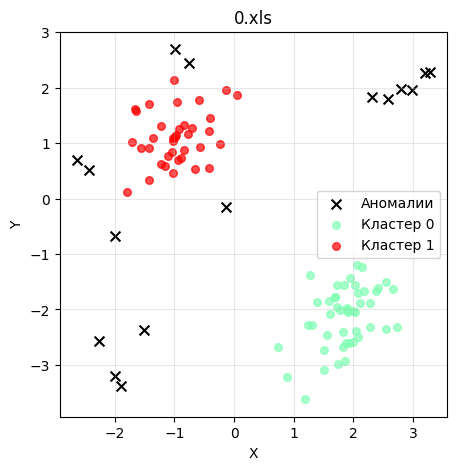


Среднее абсцисс центроидов * 100000: 124659.97
Среднее ординат центроидов * 100000: 24805.34


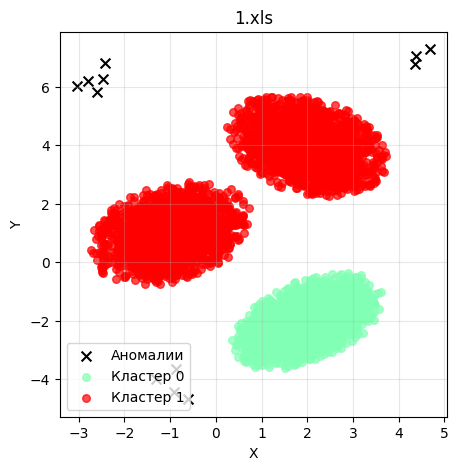


Среднее абсцисс центроидов * 100000: 517837.22
Среднее ординат центроидов * 100000: 505421.74


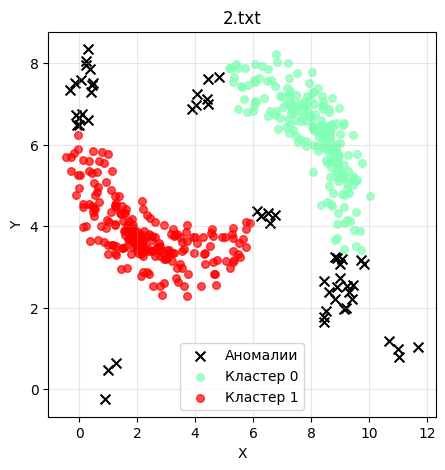


Среднее абсцисс центроидов * 100000: 472968.61
Среднее ординат центроидов * 100000: 404287.74


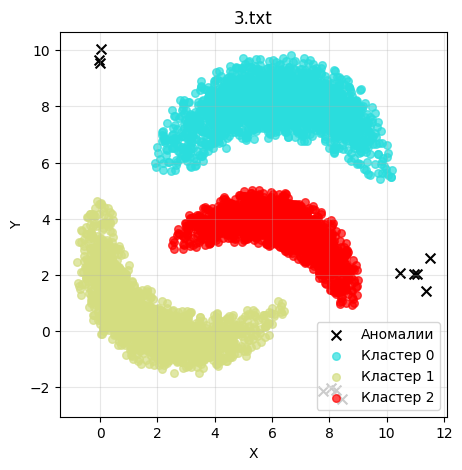


Среднее абсцисс центроидов * 100000: 524576.79
Среднее ординат центроидов * 100000: 77416.78


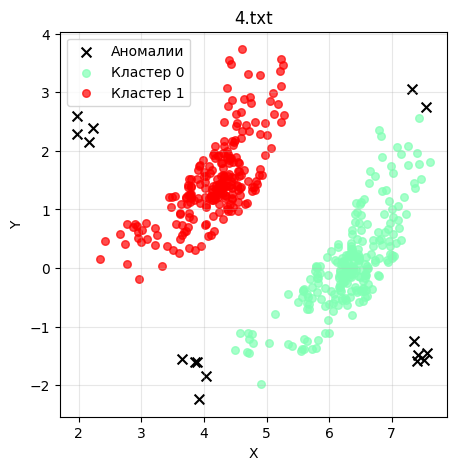


Среднее абсцисс центроидов * 100000: 667033.01
Среднее ординат центроидов * 100000: 369098.31


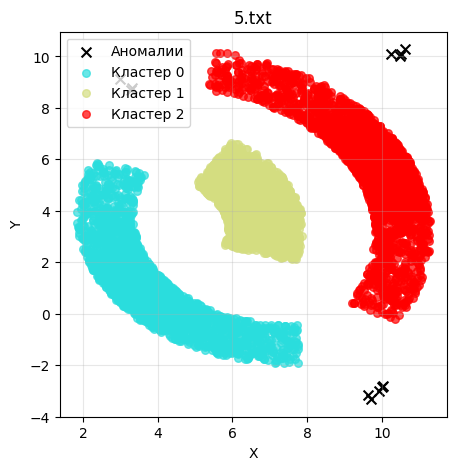

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from collections import deque
from scipy.spatial import KDTree

def my_dbscan(points, eps, min_pts):
    n = len(points)
    labels = [-2] * n
    cluster_id = 0

    # Строим KD-дерево для быстрого поиска соседей (O(n log n))
    tree = KDTree(points)

    for i in range(n):
        if labels[i] != -2:
            continue

        # Быстрый поиск соседей через дерево (O(log n) в среднем)
        neighbors = tree.query_ball_point(points[i], eps)

        if len(neighbors) < min_pts:
            labels[i] = -1
            continue

        queue = deque([i])
        labels[i] = cluster_id

        while queue:
            current = queue.popleft()
            # Используем дерево для каждого запроса
            current_neighbors = tree.query_ball_point(points[current], eps)

            if len(current_neighbors) >= min_pts:
                for neighbor in current_neighbors:
                    if labels[neighbor] == -2:
                        queue.append(neighbor)
                        labels[neighbor] = cluster_id
                    elif labels[neighbor] == -1:
                        labels[neighbor] = cluster_id

        cluster_id += 1

    return labels

def read_points(filename):
    points = []
    with open(filename, 'r') as f:
        next(f)  # пропускаем заголовок X,Y
        for line in f:
            if line.strip():
                x, y = map(float, line.strip().split(','))
                points.append([x, y])
    return np.array(points)

def process_file(filename):
  if filename.endswith('.xls'):
    df = pd.read_excel(filename, skiprows=1, header=None)
    points = df.values
  else :
    points = read_points(filename)

  labels = my_dbscan(points, 1.0, 30)

  unique_labels = set(labels)
  n_clusters = len([l for l in unique_labels if l != -1])
  n_noise = list(labels).count(-1)


  centroids = []
  for label in unique_labels:
      if label != -1:
          cluster_points = points[[i for i, l in enumerate(labels) if l == label]]
          centroid = np.mean(cluster_points, axis=0)
          centroids.append(centroid)


  if centroids:
      centroids = np.array(centroids)
      mean_x = np.mean(centroids[:, 0]) * 100000
      mean_y = np.mean(centroids[:, 1]) * 100000
      print(f"\nСреднее абсцисс центроидов * 100000: {mean_x:.2f}")
      print(f"Среднее ординат центроидов * 100000: {mean_y:.2f}")

  plt.figure(figsize=(5, 5))
  colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_labels)))

  for label, color in zip(sorted(unique_labels), colors):
      if label == -1:
          pts = points[[i for i, l in enumerate(labels) if l == -1]]
          if len(pts) > 0:
              plt.scatter(pts[:, 0], pts[:, 1], c='black', marker='x', s=50, label='Аномалии')
      else:
          pts = points[[i for i, l in enumerate(labels) if l == label]]
          plt.scatter(pts[:, 0], pts[:, 1], c=[color], s=30, alpha=0.7, label=f'Кластер {label}')

  plt.xlabel('X')
  plt.ylabel('Y')
  plt.title(filename)
  plt.legend()
  plt.grid(True, alpha=0.3)
  plt.show()

process_file('0.xls')
process_file('1.xls')
process_file('2.txt')
process_file('3.txt')
process_file('4.txt')
process_file('5.txt')





# Кластеризация (1 за каждый алгоритм на всех данных)

На предложенных распределениях данных проверьте предложенные алгоритмы. Постройте графики кластеризации для каждой пары алгоритм-данные, разные кластеры покрасьте разным цветом. Воспользуйтесь sklearn реализациями. Параметры кластеризации для разных алгоритмов подберите такие, чтобы алгоритмы можно было сравнивать (по возможности одинаковое количество кластеров и т.д.)

In [23]:
import time
import warnings

import numpy as np
import matplotlib.pyplot as plt

from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice

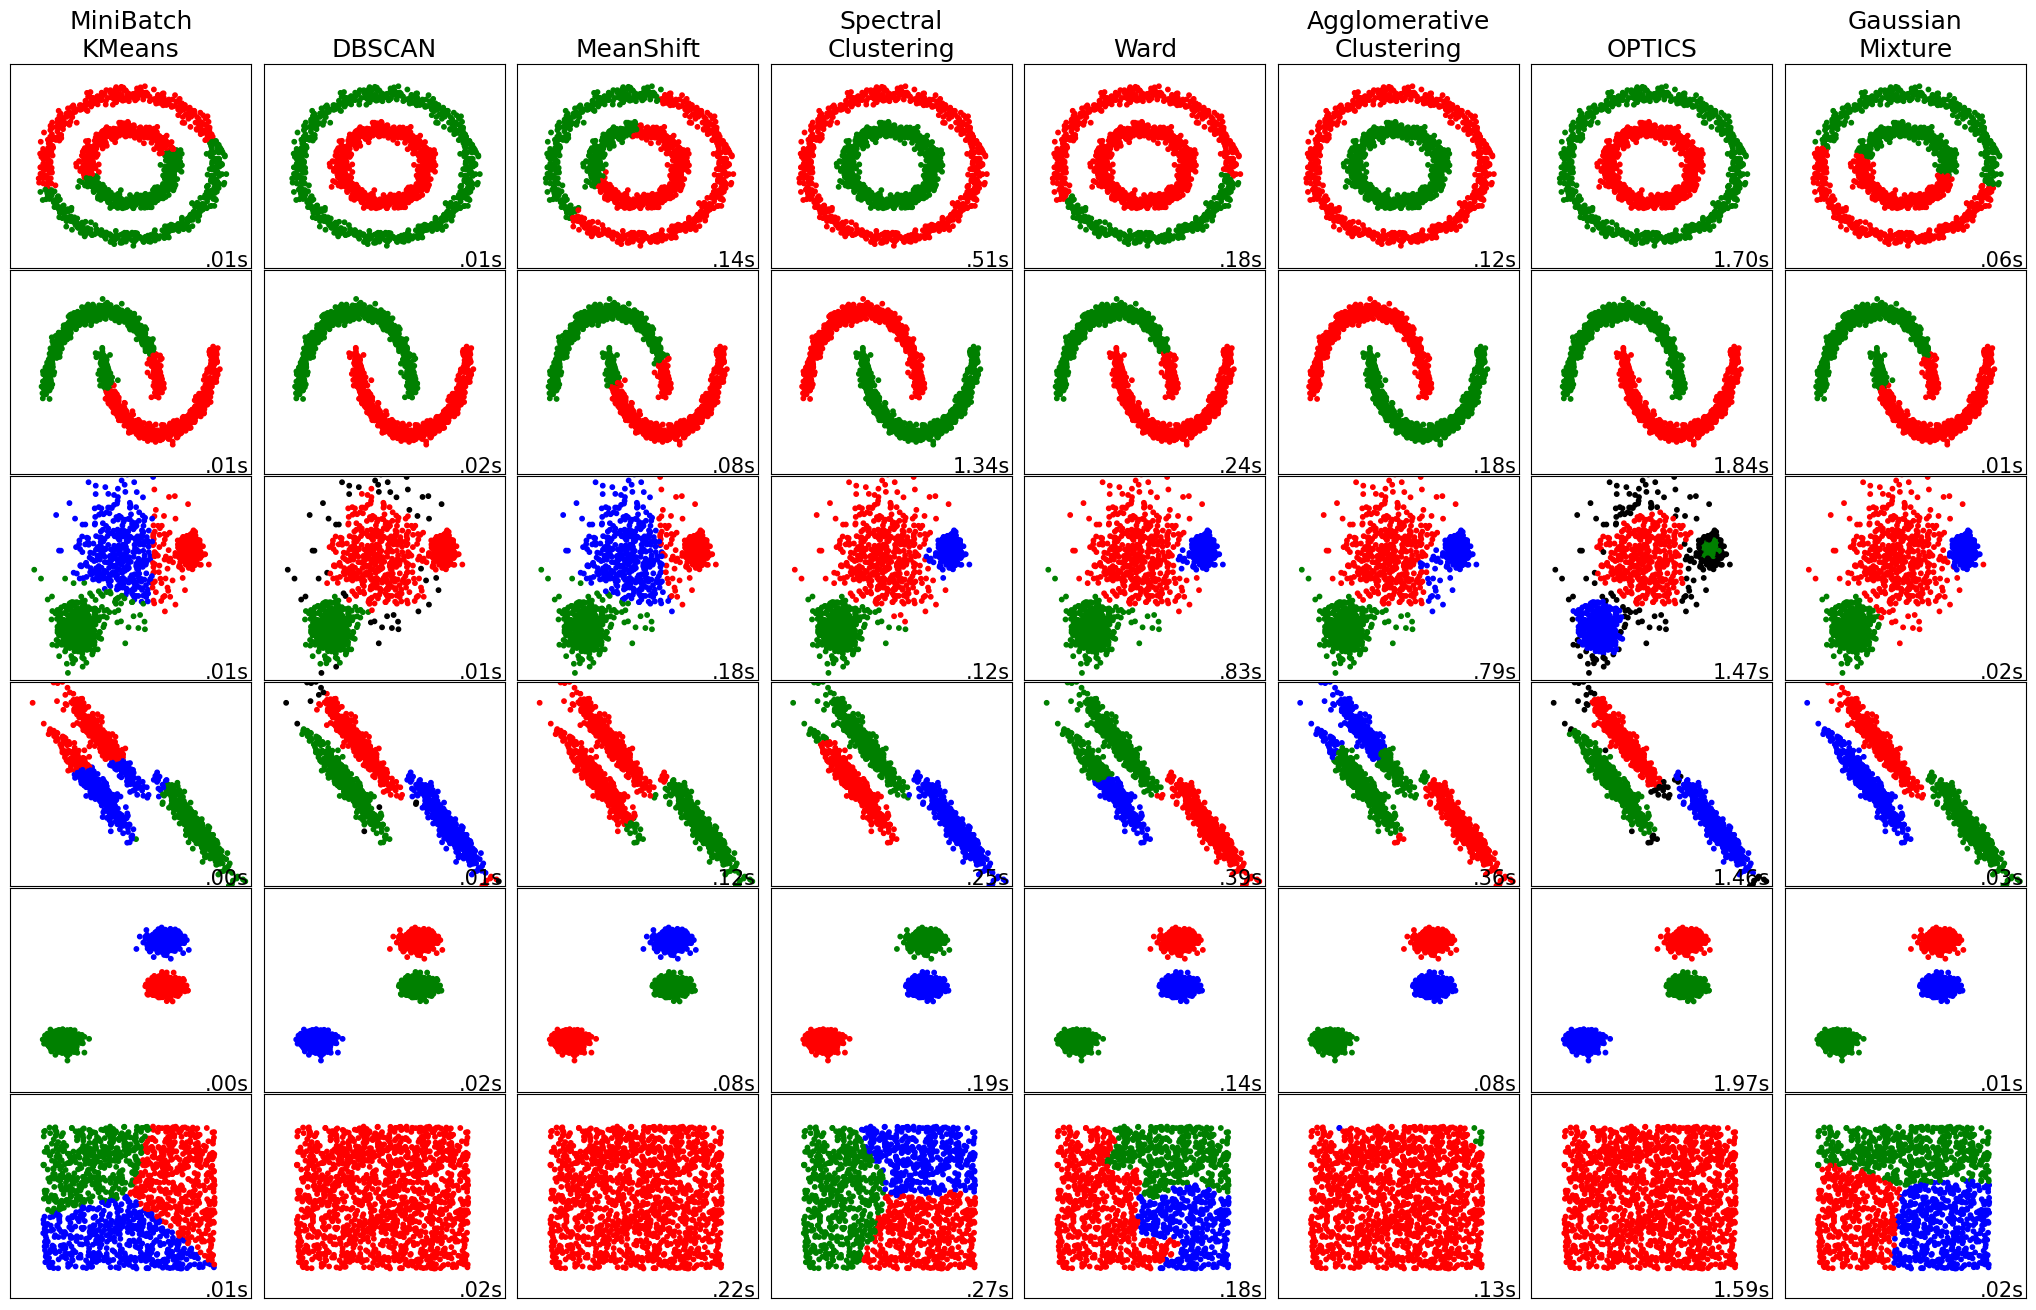

In [24]:
# ============
# Generate datasets
# ============
n_samples = 1500
noisy_circles = datasets.make_circles(n_samples=n_samples, factor=0.5, noise=0.05)
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=0.05)
blobs = datasets.make_blobs(n_samples=n_samples, random_state=8)
no_structure = np.random.rand(n_samples, 2), None

# Anisotropicly distributed data
random_state = 170
X, y = datasets.make_blobs(n_samples=n_samples, random_state=random_state)
transformation = [[0.6, -0.6], [-0.4, 0.8]]
X_aniso = np.dot(X, transformation)
aniso = (X_aniso, y)

# blobs with varied variances
varied = datasets.make_blobs(
    n_samples=n_samples, cluster_std=[1.0, 2.5, 0.5], random_state=random_state
)

# ============
# Set up cluster parameters
# ============
plt.figure(figsize=(9 * 2 + 3, 13))
plt.subplots_adjust(
    left=0.02, right=0.98, bottom=0.001, top=0.95, wspace=0.05, hspace=0.01
)

plot_num = 1

default_base = {
    "quantile": 0.3,
    "eps": 0.3,
    "damping": 0.9,
    "preference": -200,
    "n_neighbors": 10,
    "n_clusters": 3,
    "min_samples": 20,
    "xi": 0.05,
    "min_cluster_size": 0.1,
}

datasets = [
    (
        noisy_circles,
        {
            "damping": 0.77,
            "preference": -240,
            "quantile": 0.2,
            "n_clusters": 2,
            "min_samples": 20,
            "xi": 0.25,
        },
    ),
    (noisy_moons, {"damping": 0.75, "preference": -220, "n_clusters": 2}),
    (
        varied,
        {
            "eps": 0.18,
            "n_neighbors": 2,
            "min_samples": 5,
            "xi": 0.035,
            "min_cluster_size": 0.2,
        },
    ),
    (
        aniso,
        {
            "eps": 0.15,
            "n_neighbors": 2,
            "min_samples": 20,
            "xi": 0.1,
            "min_cluster_size": 0.2,
        },
    ),
    (blobs, {}),
    (no_structure, {}),
]



for i_dataset, (dataset, algo_params) in enumerate(datasets):
    # update parameters with dataset-specific values
    params = default_base.copy()
    params.update(algo_params)

    X, y = dataset

    # normalize dataset for easier parameter selection
    X = StandardScaler().fit_transform(X)

    # estimate bandwidth for mean shift
    bandwidth = cluster.estimate_bandwidth(X, quantile=params["quantile"])

    # connectivity matrix for structured Ward
    connectivity = kneighbors_graph(
        X, n_neighbors=params["n_neighbors"], include_self=False
    )
    # make connectivity symmetric
    connectivity = 0.5 * (connectivity + connectivity.T)

    # Обновляем параметры алгоритмов для каждого датасета
    two_means = cluster.MiniBatchKMeans(n_clusters=params["n_clusters"])
    dbscan = cluster.DBSCAN(eps=params["eps"])
    ms = cluster.MeanShift(bandwidth=bandwidth, bin_seeding=True)
    spectral = cluster.SpectralClustering(
        n_clusters=params["n_clusters"],
        eigen_solver="arpack",
        affinity="nearest_neighbors",
    )
    ward = cluster.AgglomerativeClustering(
        n_clusters=params["n_clusters"], linkage="ward", connectivity=connectivity
    )
    average_linkage = cluster.AgglomerativeClustering(
        n_clusters=params["n_clusters"],
        linkage="average",
        connectivity=connectivity,
    )
    optics = cluster.OPTICS(
        min_samples=params["min_samples"],
        xi=params["xi"],
        min_cluster_size=params["min_cluster_size"],
    )
    gmm = mixture.GaussianMixture(
        n_components=params["n_clusters"], covariance_type="full"
    )

    clustering_algorithms = [
        ("MiniBatch\nKMeans", two_means),
        ("DBSCAN", dbscan),
        ("MeanShift", ms),
        ("Spectral\nClustering", spectral),
        ("Ward", ward),
        ("Agglomerative\nClustering", average_linkage),
        ("OPTICS", optics),
        ("Gaussian\nMixture", gmm),
    ]

    for name, algorithm in clustering_algorithms:
        t0 = time.time()

        # catch warnings related to kneighbors_graph
        with warnings.catch_warnings():
            warnings.filterwarnings(
                "ignore",
                message="the number of connected components of the "
                + "connectivity matrix is [0-9]{1,2}"
                + " > 1. Completing it to avoid stopping the tree early.",
                category=UserWarning,
            )
            warnings.filterwarnings(
                "ignore",
                message="Graph is not fully connected, spectral embedding"
                + " may not work as expected.",
                category=UserWarning,
            )
            algorithm.fit(X)

        t1 = time.time()

        if hasattr(algorithm, "labels_"):
            y_pred = algorithm.labels_.astype(int)
        else:
            y_pred = algorithm.predict(X)

        # plot
        plt.subplot(len(datasets), len(clustering_algorithms), plot_num)
        if i_dataset == 0:
            plt.title(name, size=18)

        colors = np.array(list(islice(cycle([
            'red', 'green', 'blue',
        ]), int(max(y_pred) + 1))))
        colors = np.array(colors)
        colors = np.append(colors, ["#000000"])
        plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[y_pred])

        plt.xlim(-2.5, 2.5)
        plt.ylim(-2.5, 2.5)
        plt.xticks(())
        plt.yticks(())
        plt.text(
            0.99,
            0.01,
            ("%.2fs" % (t1 - t0)).lstrip("0"),
            transform=plt.gca().transAxes,
            size=15,
            horizontalalignment="right",
        )
        plot_num += 1

plt.show()